In [2]:
import numpy as np
caffe_root = '../../'
import sys
sys.path.insert(0, caffe_root+'python')
import caffe

caffe.set_mode_gpu()
net = caffe.Net('deploy.prototxt','../nin/nin_iter_18000.caffemodel', caffe.TEST)

In [21]:
mean = caffe.proto.caffe_pb2.BlobProto()
mean.ParseFromString(open('../imagenet_mean.binaryproto').read())
mean2 = np.load('./imagenet_mean.npy')
print mean2.shape
print np.array(mean.data).reshape(3,256,256).mean(1).mean(1), mean2.mean(1).mean(1)

(3, 256, 256)
[ 104.00698793  116.66876762  122.67891434] [ 104.00698793  116.66876762  122.67891434]


In [16]:
def getImage(loc):
    import Image
    img = Image.open(loc)
    
    return np.array(img)

def getActivation(locs):
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
    transformer.set_transpose('data', (2,0,1))
    transformer.set_mean('data', np.load('./imagenet_mean.npy')) # mean pixel
    transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
    transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB
    
    ret = {};
    ret['raw'] = {'loss' : np.zeros((len(locs),205)), 'pool4' : np.zeros((len(locs),205))}
    ret['avg'] = {'loss' : np.zeros(205), 'pool4' : np.zeros(205)}
    
    total_processed_images = 0;
    for i in range(0,len(locs),10):
        data = [];
        real_cnt = 0;
        cnt = min(i+10,len(locs))-i;
        for j in range(i,i+cnt):
            img = getImage(locs[j]);
            if( img.shape != (256,256,3) ) :
                continue;
            real_cnt = real_cnt + 1
            data.append(transformer.preprocess('data',img))
        ret['raw']['loss'][i:i+real_cnt,:] = net.forward_all(data=np.asarray(data))['loss'].reshape(real_cnt,205)
        ret['raw']['pool4'][i:i+real_cnt,:] = net.blobs['pool4'].data[0:real_cnt,:,:,:].reshape(real_cnt,205)
        total_processed_images = total_processed_images + real_cnt;
    ret['avg']['pool4'] = np.sum(ret['raw']['pool4'],axis=0) / total_processed_images
    return ret

In [4]:
loc_labels = open('/storage/datasets/mit-places/trainvalsplit_places205/train_places205.txt').readlines()

locs = [];
for i in range(0,205):
    locs.append([])
    
for loc_label in loc_labels:
    loc,label = loc_label.split(' ')
    locs[int(label)].append(loc)
    
labels = [];
for i in range(0,205):
    labels.append(('_').join(locs[i][0].split('/')[7:-1]))

['abbey', 'airport_terminal', 'alley', 'amphitheater', 'amusement_park', 'aquarium', 'aqueduct', 'arch', 'art_gallery', 'art_studio', 'assembly_line', 'attic', 'auditorium', 'apartment_building_outdoor', 'badlands', 'ballroom', 'bamboo_forest', 'banquet_hall', 'bar', 'baseball_field', 'basement', 'basilica', 'bayou', 'beauty_salon', 'bedroom', 'boardwalk', 'boat_deck', 'bookstore', 'botanical_garden', 'bowling_alley', 'boxing_ring', 'bridge', 'building_facade', 'bus_interior', 'butchers_shop', 'butte', 'bakery_shop', 'cafeteria', 'campsite', 'candy_store', 'canyon', 'castle', 'cemetery', 'chalet', 'classroom', 'closet', 'clothing_store', 'coast', 'cockpit', 'coffee_shop', 'conference_center', 'conference_room', 'construction_site', 'corn_field', 'corridor', 'cottage_garden', 'courthouse', 'courtyard', 'creek', 'crevasse', 'crosswalk', 'cathedral_outdoor', 'church_outdoor', 'dam', 'dining_room', 'dock', 'dorm_room', 'driveway', 'desert_sand', 'desert_vegetation', 'dinette_home', 'doorwa

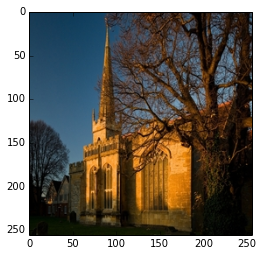

In [34]:
print labels
img = getImage(locs[0][0])
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.imshow(img)
plt.show()

In [20]:
activations = np.zeros((205,205),np.float);
for i in range(0,205):
    activations[i,:] = getActivation(locs[i][0:30])['avg']['pool4'];
    print i,

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204


In [23]:
def clustering(activations, target, num_clusters):
    import sklearn.cluster as clu

    part_activations = np.zeros((len(target),205),np.float);
    for k,i in enumerate(target):
        part_activations[k,:] = activations[i,:]
    
    ward = clu.AgglomerativeClustering(n_clusters=num_clusters).fit(part_activations)
    cluster_result = ward.labels_
    
    super_category = [];
    for i in range(0,num_clusters):
        cluster = [];
        for j in range(0,len(target)):
            if cluster_result[j] == i:
                cluster.append(target[j])
        #if( len(cluster) > 6 ):
        #   cluster = clustering(activations, cluster, 2)
        super_category.append(cluster);
    return super_category

def print_cluster(cluster,depth):
    
    print '%schildren {'%depth
    if isinstance( cluster, int ) :
        import sys
        print '%slabel : '%(depth+'\t'),cluster, '#', labels[cluster]
        print '%s}'%depth
        return
    

    for i in cluster:
        print_cluster(i,depth+'\t')
    print '%s}'%depth

clusters = clustering(activations, range(0,205), 50)
print clusters
print_cluster(clusters,'\t');
        

[[38, 42, 67, 73, 86, 142, 172, 187], [19, 146, 177, 178, 190], [148, 185, 191], [10, 18, 29, 48, 72, 126, 182], [27, 44, 77, 88, 107], [104, 138, 139, 181], [17, 37, 49, 113, 152, 153], [24, 64, 70, 97, 112, 136], [26, 65, 90], [12, 15, 50, 123, 179], [59, 101, 122, 168, 169, 173], [2, 71, 75, 119], [3, 6, 41, 106, 159], [154, 195], [4, 7, 52, 81], [9, 23, 45, 66, 85, 95, 110, 127], [39, 124, 175], [76, 87, 140], [84, 93, 108, 109, 129], [60, 103, 135], [22, 63, 96, 116, 144, 156, 200], [53, 82, 83, 137, 155, 186, 201], [111, 171, 184, 199, 203], [14, 35, 40, 157], [47, 100, 102, 128, 161, 163], [56, 115, 151], [13, 32, 57, 94, 98, 120, 130, 143], [34, 36, 46, 99, 165], [147], [74, 89], [68, 69, 121, 193, 197], [25, 31, 158, 196], [170, 202], [0, 21, 61, 62, 118, 125, 133], [54, 105, 174], [16, 58, 78, 79, 149, 176], [8, 11, 20, 114, 167], [80, 141, 183, 204], [43, 162, 164], [5, 192], [30, 117], [33], [92, 160], [166], [134], [51, 150, 198], [1, 180], [132, 188, 189], [28, 55, 91, 13